# 개요
 * [구간 확진자 구하기](#구간-확진자-구하기)
 * [신한카드 매출액 그래프](#신한카드-매출액-그래프)
 * [SK텔레콤 유동인구 그래프](#SK텔레콤-유동인구-그래프)
 * [워드클라우드](#워드클라우드)
 * [확진자수, 물류 유동인구 매출 상관관계](#확진자수,-물류-유동인구-매출-상관관계)
 * [랜덤포레스트](#랜덤포레스트)

In [1]:
import re
import pickle
import pyecharts
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.ensemble import RandomForestRegressor
from matplotlib import font_manager
from matplotlib import rc
from soynlp.tokenizer import LTokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.preprocessing import MinMaxScaler
from IPython.core.display import display, HTML, set_matplotlib_formats

In [2]:
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
# 한글 깨짐 현상을 해결
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False
font_name= 'Malgun Gothic'

In [4]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize': 15}
pylab.rcParams.update(params)

In [5]:
# seaborn 폰트 설정
sns.set(style= 'whitegrid', rc= {'figure.figsize': (10,10)},
       font= font_name)

In [6]:
with open('../DATA/pickle/CJ_DATA.bin', 'rb') as f:
    cj_data = pickle.load(f)

with open('../DATA/pickle/GS_DATA.bin', 'rb') as f:
    gs_data = pickle.load(f)
    
with open('../DATA/pickle/SH_DATA.bin', 'rb') as f:
    sh_data = pickle.load(f)
    
with open('../DATA/pickle/SK_DATA.bin', 'rb') as f:
    sk_data = pickle.load(f)
    
with open('../DATA/pickle/WS_DATA.bin', 'rb') as f:
    ws_data = pickle.load(f)

In [7]:
# cj data
cj= cj_data['CJ_DATA']

# gs data
gs_total= gs_data['GS_TOTAL']
gs_category= gs_data['GS_CATEGORY']
gs_dong= gs_data['GS_DONG']

# sh data
sh_resident= sh_data['SH_RESIDENT']
sh_foreign= sh_data['SH_FOREIGN']

# sk data
sk_age= sk_data['SK_AGE']
sk_time= sk_data['SK_TIME']

# ws data
ws_mention= ws_data['WS_MENTION']
ws_sentiment= ws_data['WS_SENTIMENT']
ws_topic= ws_data['WS_TOPIC']

# 구간 확진자 구하기

In [8]:
score_data= pd.read_excel('../DATA/extra_data/score_dataset.xlsx')
score_data.rename(columns= {'Unnamed: 0': 'DATE'}, inplace= True)

# covid interval 추가
# 상위 50퍼센트 미만: 0명 - 27명 1점
# 상위 50퍼센트 이상 20퍼센트 미만: 28명 - 107명 3점
# 상위 20퍼센트 이상 10퍼센트 미만: 108명 - 242명 6점
# 상위 10퍼센트 이상 5퍼센트 미만: 243명 - 505명 10점
# 상위 5퍼센트 이상: 506명 - 15점
score_data['covid_interval'] = pd.qcut(score_data.확진자수, [0,0.5,0.8,0.9,0.95,1], labels= [1,3,6,10,20])
score_data.covid_interval = score_data.covid_interval.astype('int64')

# 요일 추가
score_data['YO'] = score_data['DATE'].map(lambda x: x.weekday())

# MinMaxScaling
scaler= MinMaxScaler()
scaled_score_data = score_data.copy()
scaled_score_data[['격리중','격리해제','검사중','결과음성','big','small','확진자수','covid_interval']]= scaler.fit_transform(score_data[['격리중','격리해제','검사중','결과음성','big','small','확진자수','covid_interval']])

# 신한카드 매출액 그래프

In [9]:
sh_gb= sh_resident.groupby(['YEAR','INDUSTRY_CODE']).sum().reset_index()

In [13]:
# 신한카드 총 매출액
fig= go.Figure()
fig.add_trace(go.Bar(x= ['2019년','2020년'], 
                     y= sh_gb.groupby('YEAR').sum().reset_index()['USE_AMT'],
                    marker_color=px.colors.sequential.Sunsetdark))
fig.update_layout(plot_bgcolor='rgb(255,255,255)',
    title='신한카드 총 매출액',
    width=1000,
    height=700,
    font=dict(
    size=25,
    color="black"
    ),
    margin=dict(l=20, r=10, t=20, b=10), paper_bgcolor="rgb(240, 240, 240)",
    xaxis_tickfont_size=20,
    yaxis=dict(
        title='총 매출액(원)',
        titlefont_size=15,
        tickfont_size=15,
        gridcolor='black',
        zeroline= True,
        zerolinecolor= 'black'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.2, # gap between bars of the same location coordinate
)
fig.show()

In [14]:
# 신한카드 의복 업종 총 매출액
fig= go.Figure()
fig.add_trace(go.Bar(x= ['2019년','2020년'], 
                     y= sh_gb[sh_gb.INDUSTRY_CODE == 42]['USE_AMT'],
                    marker_color=px.colors.sequential.Sunsetdark))
fig.update_layout(plot_bgcolor='rgb(255,255,255)',
    title='신한카드 의복 업종 총 매출액',
    width=1000,
    height=700,
    font=dict(
    size=25,
    color="black"
    ),
    margin=dict(l=20, r=10, t=20, b=10), paper_bgcolor="rgb(240, 240, 240)",
    xaxis_tickfont_size=20,
    yaxis=dict(
        title='총 매출액(원)',
        titlefont_size=15,
        tickfont_size=15,
        gridcolor='black',
        zeroline= True,
        zerolinecolor= 'black'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.2, # gap between bars of the same location coordinate
)
fig.show()

# SK텔레콤 유동인구 그래프

In [16]:
sk_gb= sk_time.groupby('YEAR').sum()

In [17]:
# SK텔레콤 총 유동인구
fig= go.Figure()
fig.add_trace(go.Bar(x= ['2019년','2020년'], 
                     y= sk_gb.iloc[:,2:].sum(axis=1),
                    marker_color=px.colors.sequential.Sunsetdark))
fig.update_layout(plot_bgcolor='rgb(255,255,255)',
    title='SK텔레콤 총 유동인구',
    width=1000,
    height=700,
    font=dict(
    size=25,
    color="black"
    ),
    xaxis_tickfont_size=20,
    margin=dict(l=20, r=10, t=20, b=10), paper_bgcolor="rgb(240, 240, 240)",
    yaxis=dict(
        title='총 유동인구(명)',
        titlefont_size=15,
        tickfont_size=15,
        gridcolor='black',
        zeroline= True,
        zerolinecolor= 'black'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.2, # gap between bars of the same location coordinate
)
fig.show()

In [18]:
# SK텔레콤 총 유동인구
fig= go.Figure()
fig.add_trace(go.Bar(x= ['2019년','2020년'], 
                     y= sk_gb['TMST_17'],
                    marker_color=px.colors.sequential.Sunsetdark))
fig.update_layout(plot_bgcolor='rgb(255,255,255)',
    title='SK텔레콤 17시 유동인구',
    width=1000,
    height=700,
    font=dict(
    size=25,
    color="black"
    ),
    margin=dict(l=20, r=10, t=20, b=10), paper_bgcolor="rgb(240, 240, 240)",
    xaxis_tickfont_size=20,
    yaxis=dict(
        title='총 유동인구(명)',
        titlefont_size=15,
        tickfont_size=15,
        gridcolor='black',
        zeroline= True,
        zerolinecolor= 'black'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.2, # gap between bars of the same location coordinate
)
fig.show()

# 워드클라우드

In [19]:
# 한글 폰트 설정
path= 'c:/Windows/Fonts/malgun.ttf'
font_name= font_manager.FontProperties(fname= path).get_name()
plt.rcParams['font.family']= font_name

# 마이너스 깨짐 설정
import matplotlib as mpl

mpl.rcParams['axes.unicode_minus'] = False

# 화면 설정
set_matplotlib_formats('retina')

In [20]:
def title_to_word(feb):
    title = list(feb['제목'])
    title = [re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', str(t)) for t in title]
    words = []
    tokenizer = LTokenizer()
    for t in title:
        words.append(tokenizer.tokenize(t, flatten=False))
    title_words = []
    for w in words:
        for l in range(len(w)):
            title_words.append(w[l][0])
    return title_words

In [21]:
def draw_wordcloud(title_words,n):
    title_words= [word for word in title_words if word not in ['코로나','코로나19','VI','nan','포토','것"','만에','위해','속보']]
    title_words= [word for word in title_words if len(word) >= 2]
    count = Counter(title_words)
    title_words_common = dict(count.most_common(100))
    wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "Accent_r", width=1500, height=1000).generate_from_frequencies(title_words_common) 
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud) 
    plt.axis('off') 
    plt.show()

In [22]:
nn = np.arange(1,31)

# 4월
for n in nn:
    if len(str(n))==1:
        apr = pd.read_excel('../DATA/news_title/NewsResult_2020040'+str(n)+'.xlsx')
    else:
        apr = pd.read_excel('../DATA/news_title/NewsResult_202004'+str(n)+'.xlsx')
    title_words = title_to_word(apr)
    draw_wordcloud(title_words,n)

KeyboardInterrupt: 

# 확진자수, 물류 유동인구 매출 상관관계

In [55]:
# After MinMaxScaling
scaler= MinMaxScaler()
scaled_score_data = score_data.copy()
scaled_score_data[['격리중','격리해제','검사중','결과음성','big','small','확진자수','covid_interval']]= scaler.fit_transform(score_data[['격리중','격리해제','검사중','결과음성','big','small','확진자수','covid_interval']])

# Scoring
scaled_score_data['SCORE'] = 1-(0.55*scaled_score_data['격리중'] + 0.85*scaled_score_data['검사중'] - 0.85*scaled_score_data['결과음성'])

# Scaled Score
scaled_score_data['SCALED_SCORE'] = scaler.fit_transform(scaled_score_data.iloc[:,-1].to_numpy().reshape(-1,1))

In [96]:
# sk, 신한카드, cj 데이터 가공을 위한 함수
def sksk(df, flag, code):
    
    if flag:
        sk_s = df.query('(SI_CODE==@code)')
    else:
        sk_s = df
        
    age_col_list = sk_s.columns.values.tolist()
    age_col_list = age_col_list[7:22]

    temp_df = pd.DataFrame(sk_s.groupby(['DATE'])[age_col_list].sum())
    temp_df = temp_df.sum(axis=1)
    temp_df = temp_df.to_frame(name='Popul')
    pop_df = temp_df.reset_index()
    pop_df['YO'] = pop_df['DATE'].map(lambda x: x.weekday())
    
    # 2020년만 해당하도록 함
    pop_20 = pop_df.tail(121)
    
    # 그래프 보고싶으면 주석처리 빼기
#     draw(pop_20, 'DATE', 'Popul')
    
    return pop_20

def shsh(df, flag, code):
    
    if flag:
        sh_s = df.query('(SI_CODE==@code)')
    else:
        sh_s = df
    
    temp_df = pd.DataFrame(sh_s.groupby(['DATE'])['USE_AMT'].sum())
    amt_df = temp_df.reset_index()
    amt_df['YO'] = amt_df['DATE'].map(lambda x: x.weekday())
    
    # 2020년만 해당하도록 함
    amt_20 = amt_df.tail(121)
    
    # 그래프 보고싶으면 주석처리 빼기
#     draw(amt_20, 'DATE', 'USE_AMT')
    
    return amt_20

def cjcj(df, flag, code):
    
    if flag:
        cj_s = df.query('(SI_CODE==@code)')
    else:
        cj_s = df
    
    temp_df = pd.DataFrame(cj_s.groupby(['DATE'])['TRANSIT_COUNT'].sum())
    transit_df = temp_df.reset_index()
    transit_df['YO'] = transit_df['DATE'].map(lambda x: x.weekday())
    
    # 2020년만 해당하도록 함
    transit_20 = transit_df.tail(121)
    
    # 그래프 보고싶으면 주석처리 빼기
#     draw(amt_20, 'DATE', 'USE_AMT')
    
    return transit_20

# plot을 위한 함수
def draw(df, x_col, y_col):
    label = df[x_col]
    index = range(len(label))

    plt.figure(figsize=(30,10))
    plt.plot(index, df[y_col], '>-')
    plt.xticks(index[::7], label[::7], rotation='45')
    plt.grid(axis='x')
    plt.show()
    
# Scatterplot 생성을 위한 함수
def scatter(df1, df2, x_col, y_col):
    plt.figure(figsize=(20,20))
    df1['DATE'] = df1['DATE'].astype(str)
    df2['DATE'] = df2['DATE'].astype(str)
    
    sns.scatterplot(x=x_col, 
                    y=y_col, 
                    s=100, # marker size
                    data = pd.merge(df1, df2, on='DATE'))

    plt.show()

# Heatmap 생성을 위한 함수
def corr(dataframe, sk_dataframe, sh_dataframe, cj_dataframe, title):
    
    # Series로 넣는 경우는 .tolist()가 필요
    # list로 넣는경우는 .tolist() 삭제
    origin = pd.DataFrame({'확진자수':dataframe.tolist(), '유동인구':sk_dataframe.tolist(), '매출액':sh_dataframe.tolist(), '물류량':cj_dataframe.tolist()})
    origin_df = origin.corr()

    plt.figure(figsize=(12,12))

    mask = np.zeros_like(origin_df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(origin_df, annot=True, fmt = '.2f', linewidths=.5, cmap='YlGnBu', mask=mask, annot_kws={"fontsize":20})
    plt.title(title, fontsize=30)
    plt.show()
    
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 12),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [58]:
# sk, 신한, cj 데이터 가공
total_sk = sksk(sk_age, False, '00')

total_sh = shsh(sh_resident, False, '00')

total_cj = cjcj(cj, False, '00')

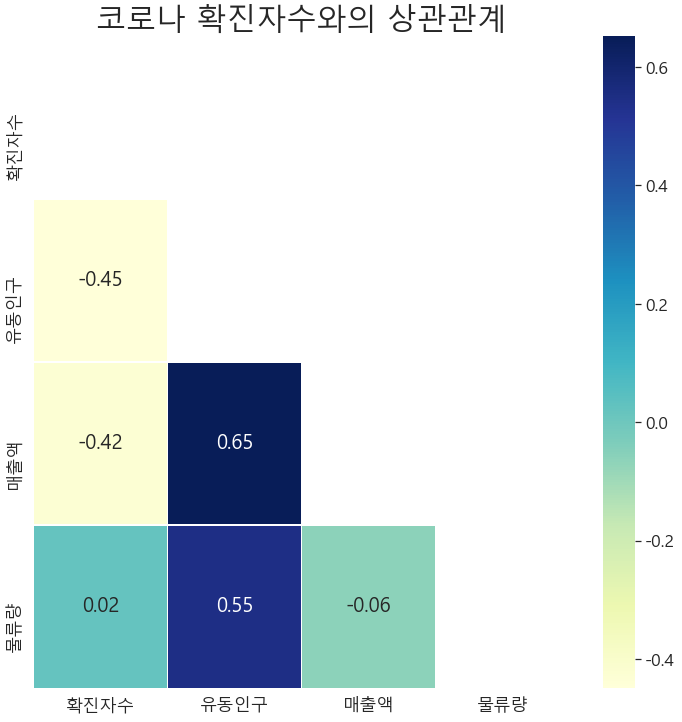

In [97]:
# 코로나데이터와 업종별 상관관계
corr(scaled_score_data['확진자수'], total_sk['Popul'], total_sh['USE_AMT'], total_cj['TRANSIT_COUNT'], '코로나 확진자수와의 상관관계')

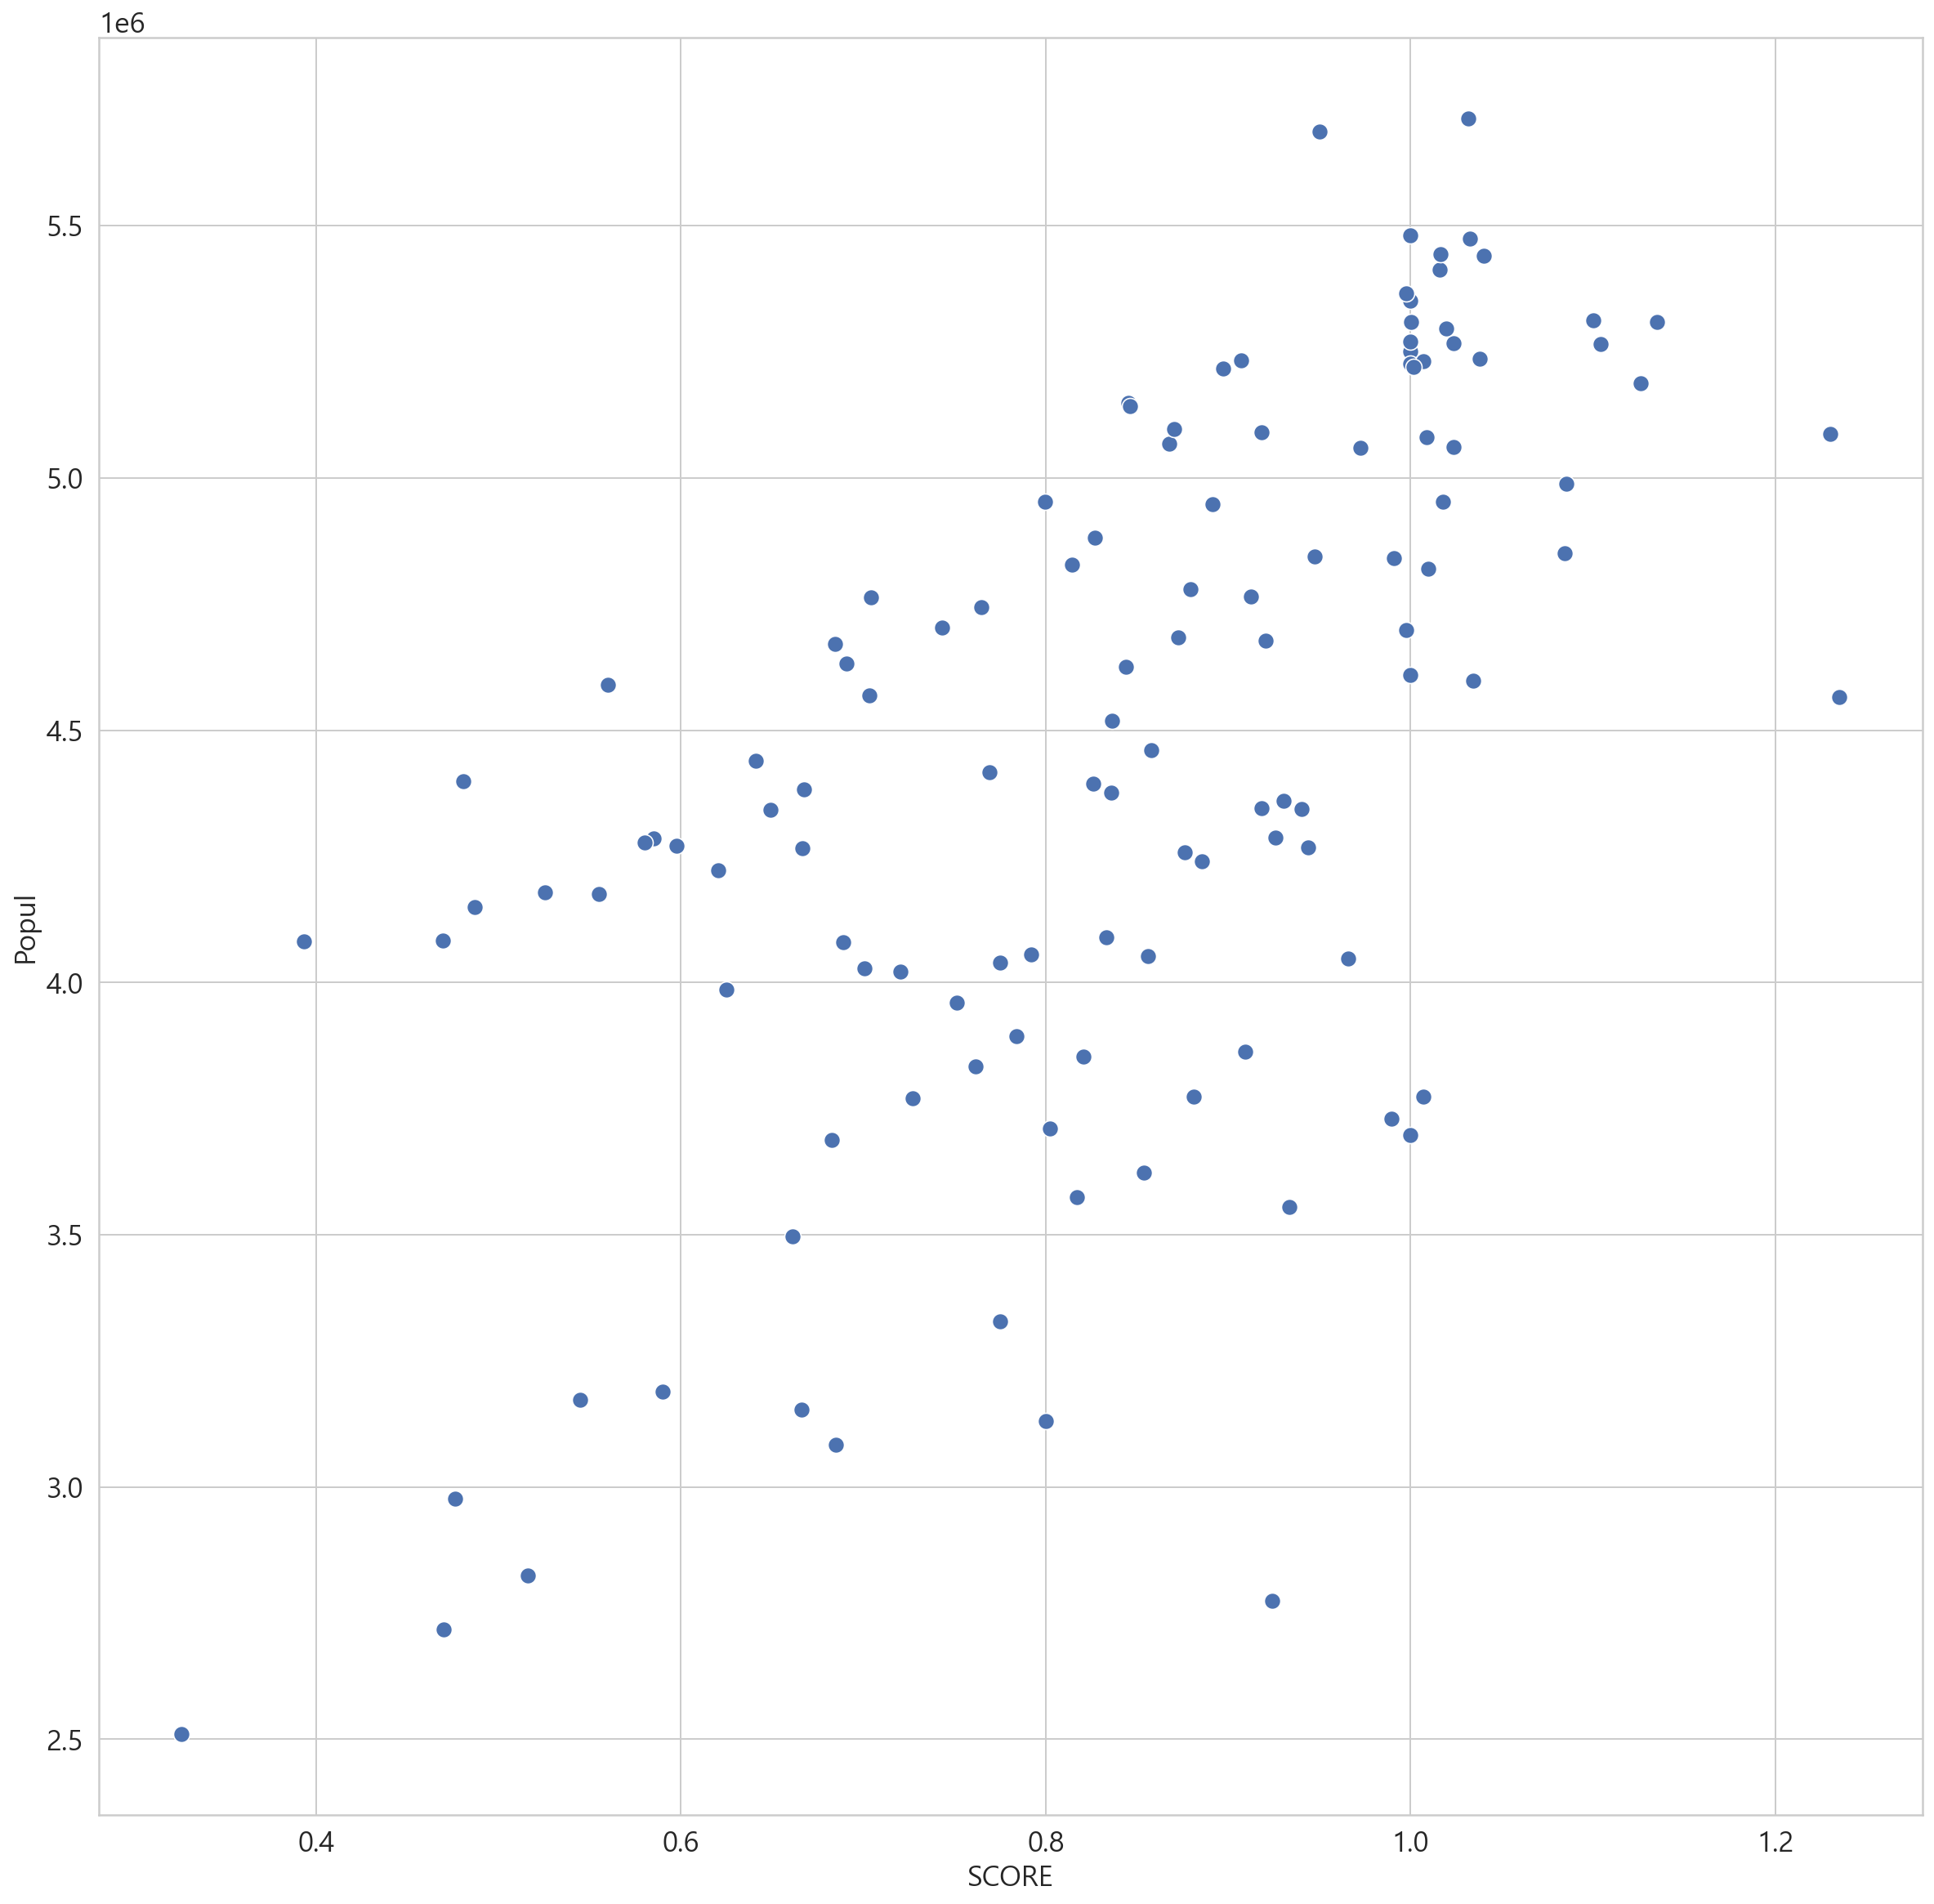

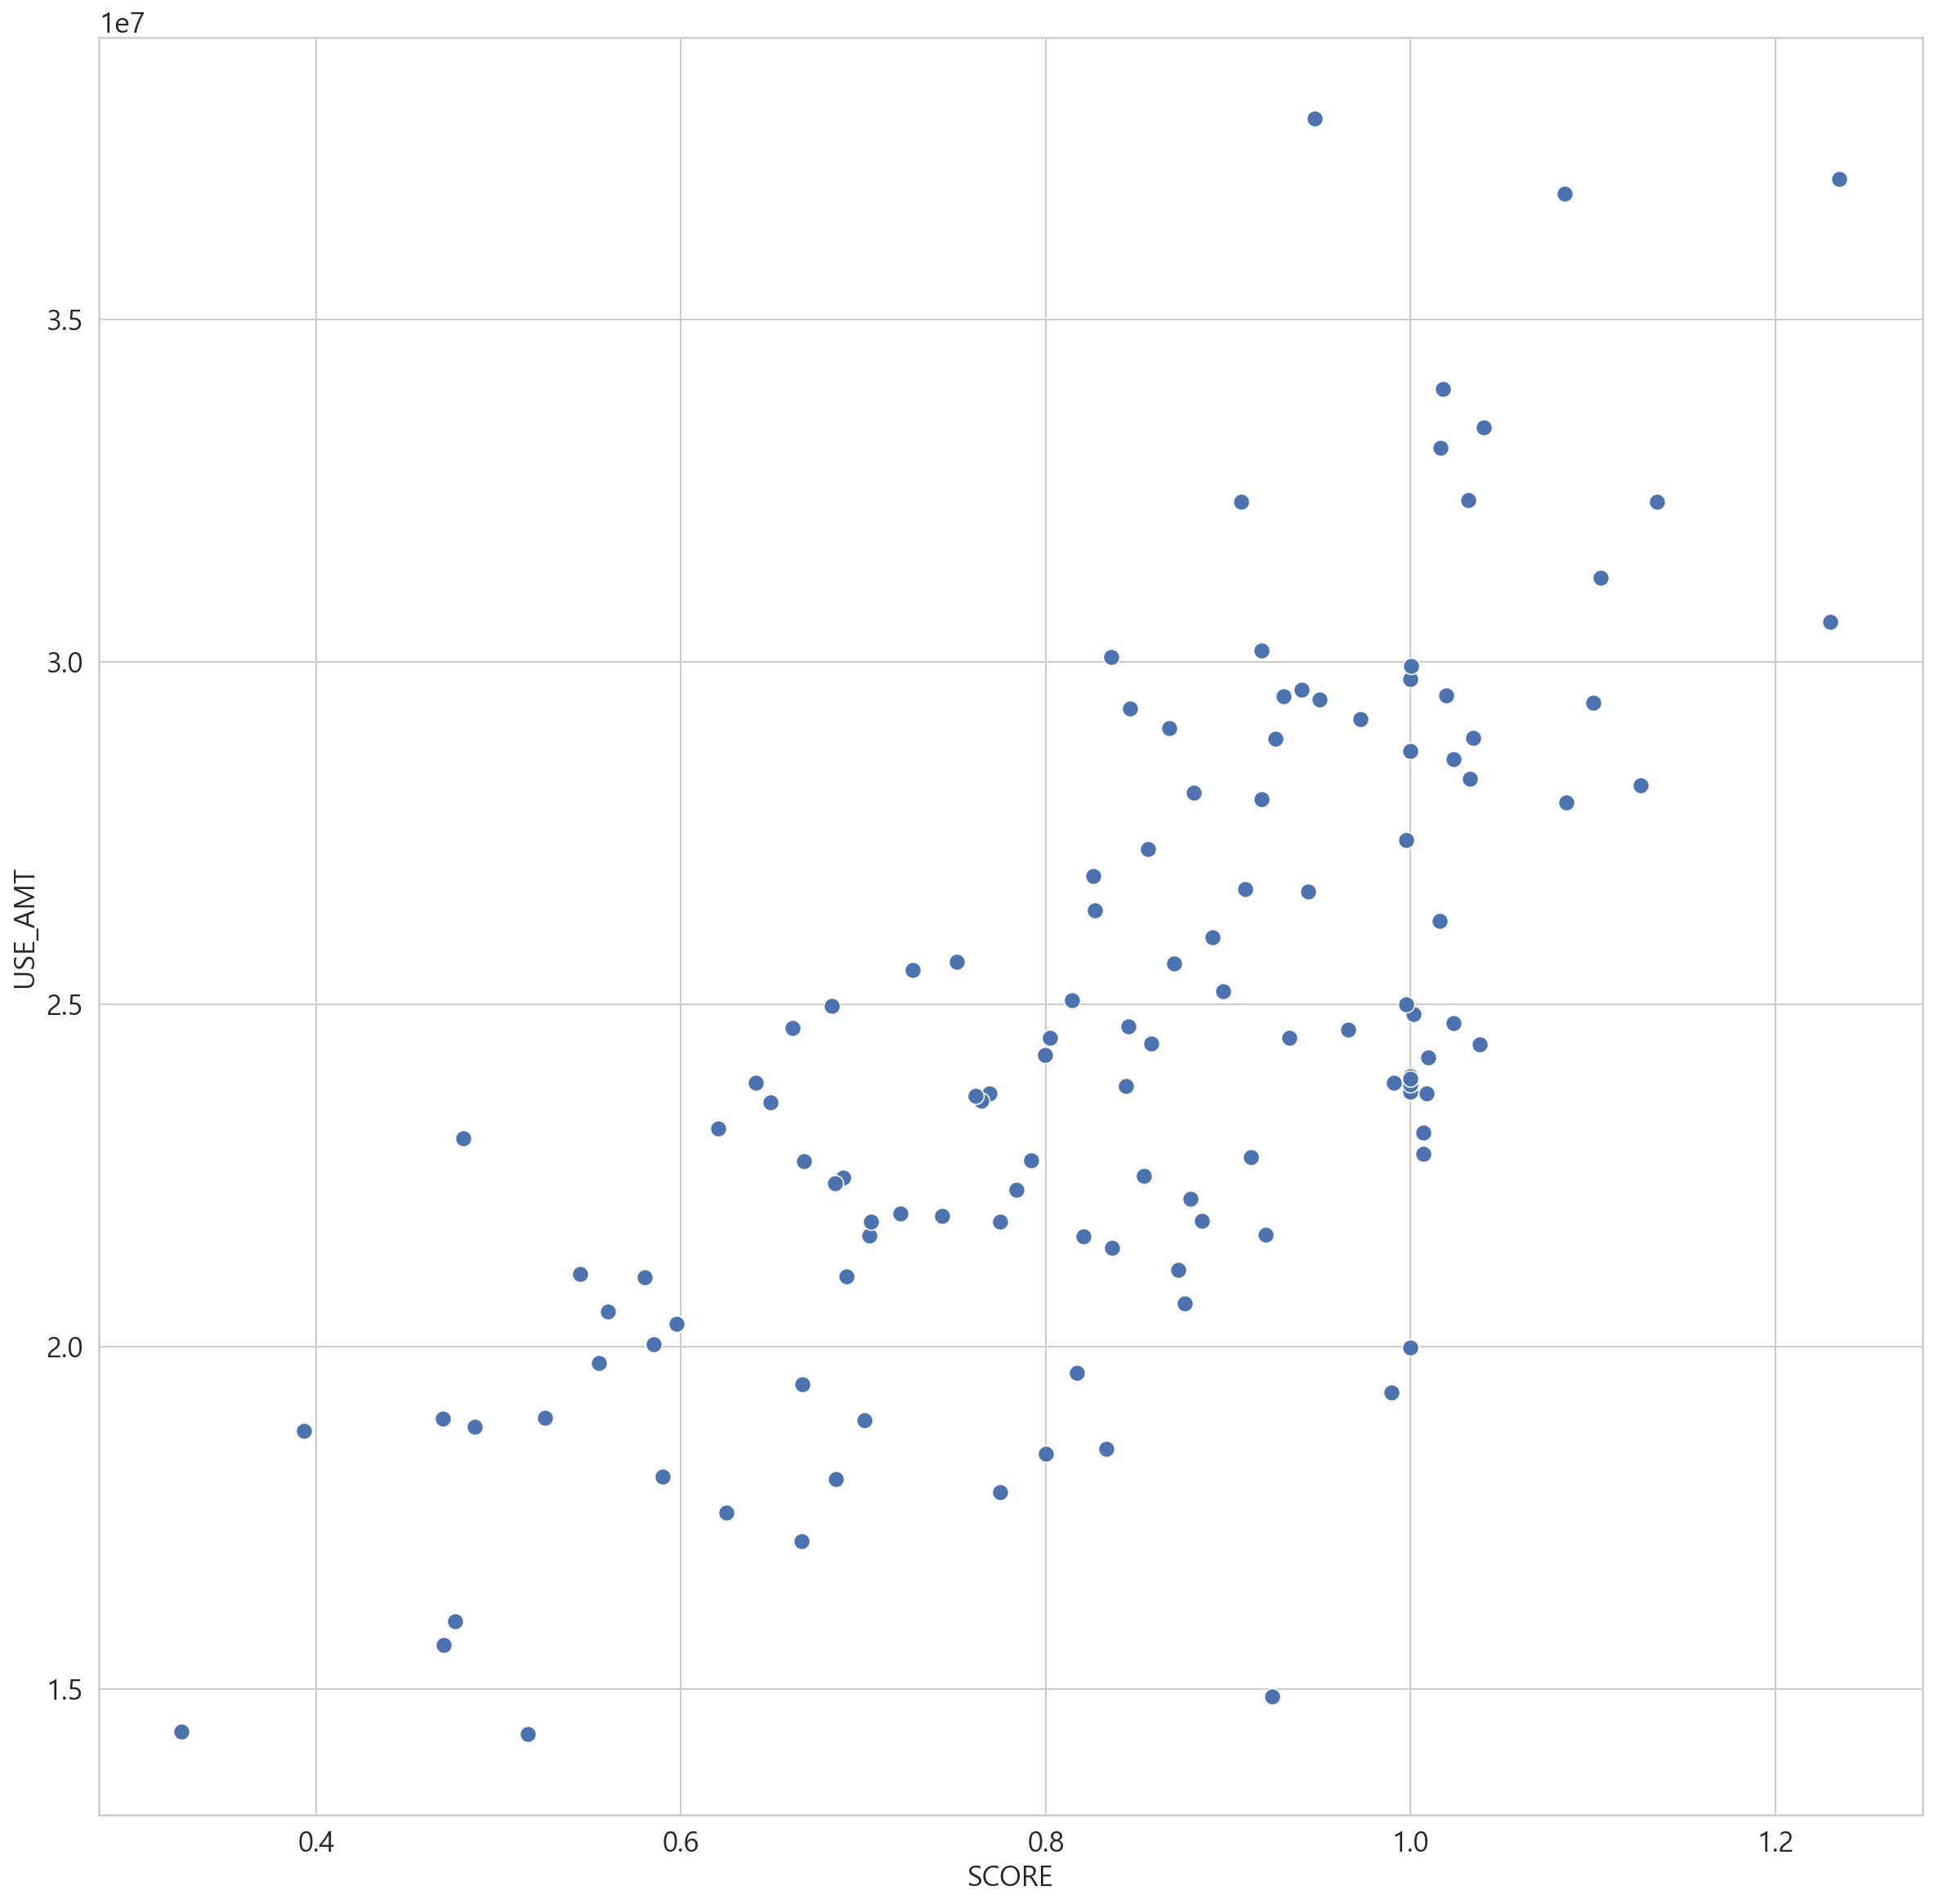

In [19]:
# Event score와 유동인구, 매출액 scatterplot
scatter(scaled_score_data, total_sk, 'SCORE', 'Popul')

scatter(scaled_score_data, total_sh, 'SCORE', 'USE_AMT')

# 랜덤포레스트

In [87]:
# 랜덤포레스트 생성을 위한 함수
def RandomForestResult(x, y, ccp_alpha, state_num,title):
    label = x.columns
    index = np.arange(len(label))
    
    RFC = RandomForestRegressor(ccp_alpha= ccp_alpha, random_state = state_num)
    RFC.fit(x, y)
    print(RFC.feature_importances_[::-1])
    plt.figure(figsize= (15,8))
    
    ax = sns.barplot(x= RFC.feature_importances_, y=index, palette='Spectral', orient='h')
    plt.yticks(index, label)
    plt.title(title, fontsize=30)
    plt.show()
    
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 15),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [60]:
# 비교를 위한 신한, sk 데이터 생성
total_sk.DATE = total_sk.DATE.astype('datetime64')
total_sh.DATE = total_sh.DATE.astype('datetime64')

score_data_sh= pd.merge(score_data, total_sh.iloc[:,0:2], on='DATE')
score_data_sk= pd.merge(score_data, total_sk.iloc[:,0:2], on='DATE')

score_data_sh.rename(columns = {'big': '큰 사건의 횟수', 'small': '작은 사건의 횟수','covid_interval': '구간화된 확진자수'}, inplace= True)
score_data_sk.rename(columns = {'big': '큰 사건의 횟수', 'small': '작은 사건의 횟수','covid_interval': '구간화된 확진자수'}, inplace= True)

[0.00977703 0.1421689  0.01928512 0.02481222 0.16438523 0.08021974
 0.35667638 0.20267538]


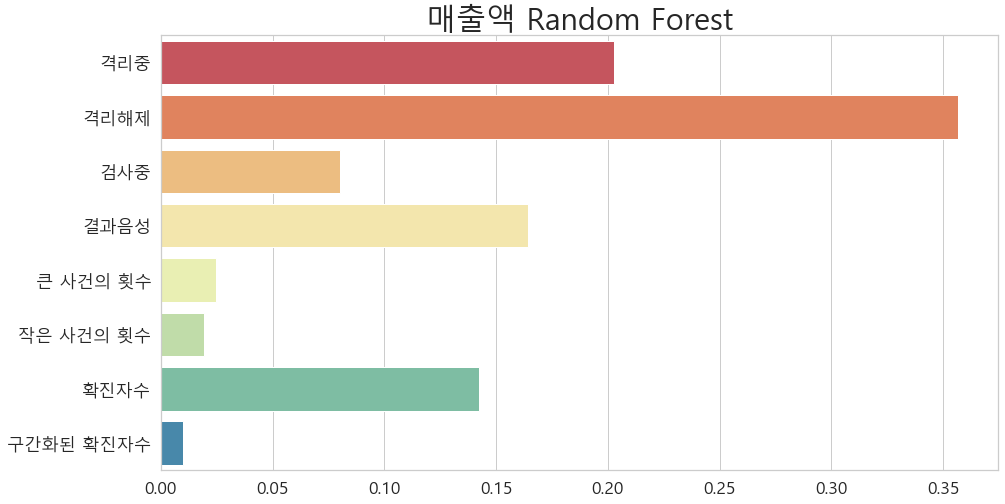

In [88]:
# 신한카드 열 전부 포함
RandomForestResult(score_data_sh.iloc[:,1:9],score_data_sh.iloc[:,-1],10,2,'매출액 Random Forest')

[0.01916645 0.32059907 0.03515217 0.04620385 0.13305378 0.09801205
 0.10953066 0.23828197]


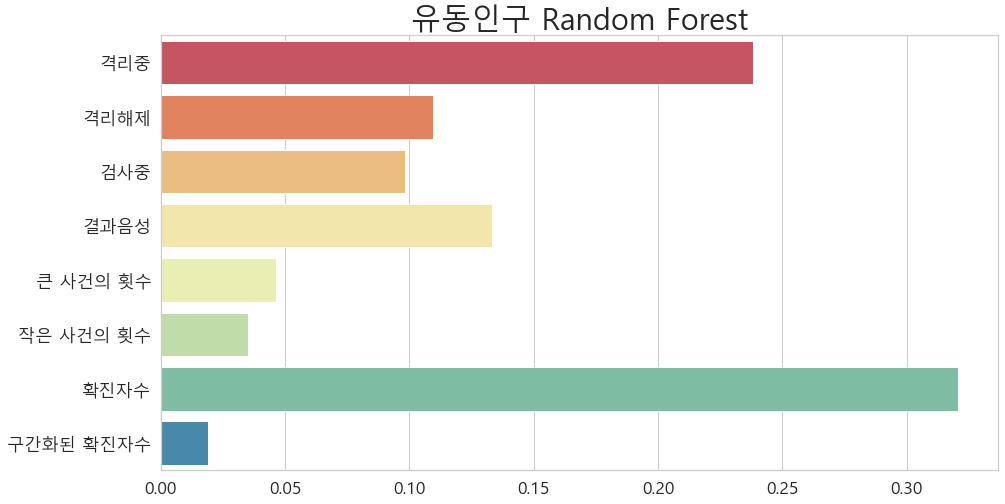

In [82]:
# sk 열 전부 포함
RandomForestResult(score_data_sk.iloc[:,1:9],score_data_sk.iloc[:,-1],10,5,'유동인구 Random Forest')